In [1]:
#cd ~/Desktop/covid_machinations
!pwd

/Users/edwardterrell/Desktop/covid_machinations


In [2]:
ls

ColoradoOutbreaks.ipynb         environment.yml
LICENSE                         pie_dict.py*
README.md                       population_by_country_2020.csv
__pycache__/                    state_country_dicts.py
add_populations.ipynb           state_pop.csv
covid19.ipynb                   style-notebook.css
covid_data/                     style-table.css
date_checker.py*                world_pop.csv
date_select.py*


In [3]:
# we want to ensure we are in the correct conda environment
import sys
sys.executable

# os, shutil used for copying/moving files
import os
import shutil
# shutil.copyfile('src', 'dst')
# shutil.move

import numpy as np
import pandas as pd
import openpyxl

In [4]:
# This code was used when repeatedly modifying date_checker module
#import importlib
#importlib.import_module('state_country_dicts') #note difference between this and reload
#importlib.reload(dc) #date_checker

In [5]:
# Custom pie_dict module contains only one function (pie) which reduces 
# the number of types into only seven basic categories for creating piecharts
from pie_dict import pie

In [6]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt

import requests
from bs4 import BeautifulSoup as bs
# import regular expressions
import re 

from IPython.display import Image
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

# get current date for use in creating filenames with embedded 'day'. 
# convert datetime object to string
import datetime as dt
today  = dt.date.today()
day = today.strftime('%Y-%m-%d')
day

'2022-01-14'

### The following cell determines if the Colorado site has been updated

In [7]:
# outbreaks files are updated on the web once a week usually Wed afternoon
# date_checker is a custom python module that compares the date of the
# last saved outbreak.xlsx file to the date of the outbreak.xlsx
# file on the web
import date_checker as dc

#Returns the date of the latest saved spreadsheet.
previous = dc.get_date()


# compare function outputs a tuple: url link and a date
# and prints the dates of the spreadsheets
names = dc.compare(previous)

latest saved spreadsheet is 2022-01-12
covid-19_ob_weekly_report_01_12_2022_updated.xlsx
https://covid19.colorado.gov/sites/covid19/files/documents/covid-19_ob_weekly_report_01_12_2022_updated.xlsx
Site NOT updated: current date of spreadsheet is 2022-01-12


In [8]:
# Examine the tuple
print (names[0])
print (names[1])

https://covid19.colorado.gov/sites/covid19/files/documents/covid-19_ob_weekly_report_01_12_2022_updated.xlsx
2022-01-12 00:00:00


### Colorado Outbreak data

In [9]:
import urllib
import requests
import re

url = 'https://covid19.colorado.gov/data/outbreak-data'

In [10]:
!mkdir covid_data_update

In [11]:
ls covid_data_update/

In [12]:
def get_weekly_report(names):
    '''
    Opens the web page and creates a copy of the xlsx file,
    which is then archived in the directory covid_data.
    
    names is the tuple variable created by data_checker.compare()
    the two components of names are: 1) url link and 2)date in string format
    
    returns a dataframe
    '''
    link = names[0]
    response = requests.get(link)
    with open ('temp.xlsx', 'wb') as file:
        file.write(response.content)
    
    # create a permanent copy of the xlsx file in the covid_data directory
    current = names[1]
    current_report = current.strftime('%Y-%m-%d')
    shutil.copyfile('temp.xlsx', f'covid_data/covid_report_{current_report}.xlsx')
    
    df = pd.read_excel('temp.xlsx',sheet_name='Active',engine='openpyxl',parse_dates=['Date reported to public health'])
    return df

In [13]:
df = get_weekly_report(names)
df.shape

(889, 65)

In [14]:
df = df.iloc[:,:16]
df.head(3)

,Setting name,Investigation status,Date outbreak was considered closed:,COVID Setting Type,"If setting type is other, specify","Is this an At Risk Population? (Healthcare, Corrections, Highly Mobile, Schools, Critical Infrastructure)",Colorado county (exposure location),Date reported to public health,Total resident cases,Total staff cases,Total attendee cases,Total resident deaths,Total staff deaths,Total attendee deaths,Total cases,Total deaths
0,23rd St Group Home (05R955),Active,NaN,Healthcare - Group Home,NaN,Yes,Mesa,2021-12-28,NaN,2.0,NaN,NaN,NaN,NaN,2,0
1,29 and One Half Road Group Home (05T700),Active,NaN,Healthcare - Group Home,NaN,Yes,Mesa,2021-12-01,5.0,4.0,NaN,NaN,NaN,NaN,9,0
2,48th Avenue - Catholic Charities Women's Shelter,Active,NaN,Homeless Shelter,NaN,Yes,Denver,2021-11-29,19.0,2.0,NaN,NaN,NaN,NaN,21,0


In [15]:
def polish_report(df):
    '''polish_report removes and reorders columns and assigns shortened names. It also
    creates a datetime index, changes strings to integers and handles NaNs
    Returns: a copy of the original df
    '''
    # eliminate unnecessary columns and re-order columns
    df = df.iloc[:,[-2,0,3,6,7,8,9,10]].copy()
    
    # shorten col names for easier manipulation
    df.columns = ['total','name','type', 'county','date','residents','staff','attendee']
    
    # use the date column as the index
    df.index = df.date
    df.drop('date',axis=1, inplace=True)
    
    # replace nuisance commas
    df.name = df.name.str.replace(',','_')
    
    # fill na with 0 and turn strings to integers
    df = df.fillna(0)
    df['attendee'] = df['attendee'].astype(int) 
    df['staff'] = df['staff'].astype(int) 
    df['residents'] = df['residents'].astype(int)
    
    return df

In [16]:
current = names[1]
current_report = current.strftime('%Y-%m-%d')

In [17]:
# create dfs for both active and resolved sheets 
for i in range(2):
    i=i+1
    sheet = pd.read_excel(f'covid_data/covid_report_{current_report}.xlsx',sheet_name=i,parse_dates=['Date reported to public health'])
    sheet = sheet.iloc[:,:16]
    sheet = polish_report(sheet)
    sheet = sheet.sort_index(ascending=False)
    if i == 1: 
        df1 = sheet.resample('M').sum()
    elif i == 2: 
        df2 = sheet.resample('M').sum()

In [18]:
# Merge both dfs into a single df "totals" and change all types to integers
totals = pd.merge(df1,df2,left_index=True, right_index=True,how='outer' ).fillna(0)
totals = totals.astype(int)
totals.tail()

,total_x,residents_x,staff_x,attendee_x,total_y,residents_y,staff_y,attendee_y
date,,,,,,,,
2021-09-30,4032,930,775,2327,3111,844,1079,1188
2021-10-31,3322,666,940,1716,3295,924,1293,1078
2021-11-30,2605,459,1064,1082,1791,369,849,573
2021-12-31,3654,902,2301,451,104,19,58,27
2022-01-31,1003,395,531,77,0,0,0,0


In [19]:
# Create a column which sums active and resolved totals
totals['all_reported_cases'] = totals.total_x+totals.total_y

# Create a Date column for plotting purposes 
# Keep only the last two columns
totals['Date'] = totals.index.strftime('%Y-%m')
totals = totals.iloc[:,-2:]
totals

,all_reported_cases,Date
date,,
2020-03-31,774,2020-03
2020-04-30,8552,2020-04
2020-05-31,2716,2020-05
2020-06-30,1102,2020-06
2020-07-31,1871,2020-07
2020-08-31,8298,2020-08
2020-09-30,2915,2020-09
2020-10-31,16379,2020-10
2020-11-30,22708,2020-11


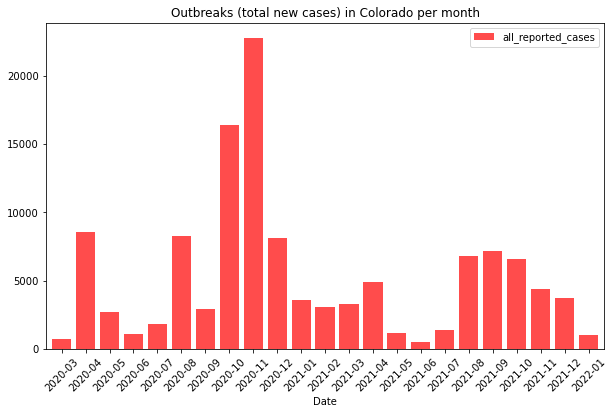

In [20]:
totals[['Date','all_reported_cases']].plot.bar(figsize=(10,6), \
                                x='Date',rot=45, width=.8, \
                                color="red",alpha=.7,\
                                title="Outbreaks (total new cases) in Colorado per month");
plt.savefig(f'./covid_data_update/outbreaks-updated-{day}.png');

### outbreaks

In [21]:
df = polish_report(df)
df = df.sort_index(ascending=False)

In [22]:
# this saves four csv files for easy viewing access even on an ipad organized by county,type, total and date
# use of f-string to allow 'day' to be interpreted correctly
df.sort_values(by='county', inplace=True)
df.to_csv(f'./covid_data_update/outbreaks-COUNTY-{day}.csv')

df.sort_values(by='type', inplace=True)
df.to_csv(f'./covid_data_update/outbreaks-TYPE-{day}.csv')

df.sort_values(by='total', inplace=True,ascending=False)
df.to_csv(f'./covid_data_update/outbreaks-TOTAL-{day}.csv')

df =df.sort_index(ascending=False)
df.to_csv(f'./covid_data_update/outbreaks-DATE-{day}.csv')

# total active
print(f'There are {df.shape[0]} outbreak sites and {df.total.sum()} active cases in Colorado')

There are 889 outbreak sites and 23080 active cases in Colorado


In [23]:
# Future modification planned to show data across year boundaries
# dfy is the df for the current year
dfy = df[df.index.year==today.year].copy()

In [24]:
# df_month is the df for the selected month
df_month = dfy[dfy.index.month==today.month].copy()

df_month.total.sum()

1003

In [26]:
#df_month.reset_index(inplace=True)
df_month = df_month[['total','name','type','county']]
df_month.head(20)

,total,name,type,county
date,,,,
2022-01-11,2,Forest Street Compassionate Care Center (02H51...,Healthcare - Skilled Nursing,Denver
2022-01-10,13,Cotopaxi School Fremont RE3: January 2022,School K-12,Fremont
2022-01-10,2,Grand Junction Regional Center - House 11,Healthcare - Group Home,Colorado
2022-01-10,5,The Salvation Army RJ Montgomery Center: Janua...,Homeless Shelter,El Paso
2022-01-09,6,Hope Montessori Academy- Thornton: January 2022,Child Care Center,Adams
2022-01-08,6,The Retreat at Sunny Vista (23Q180): January 2022,Healthcare - Assisted Living,El Paso
2022-01-08,7,Brookdale Pinehurst Park (2304CA): January 2022,Healthcare - Assisted Living,Denver
2022-01-08,8,Sunrise at Pinehurst (23049U): January 2022,Healthcare - Assisted Living,Denver
2022-01-07,6,The Manor on Marion Circle (2304C8),Healthcare - Assisted Living,Arapahoe


In [27]:
# get number of sites and total cases for the month
s_num = df_month.shape[0]
t = df_month.total.sum()
print(f'There were an additional {s_num} outbreak sites in Colorado this month.')
print (f'These represent a total of {t} new cases.')

There were an additional 122 outbreak sites in Colorado this month.
These represent a total of 1003 new cases.


In [28]:
# list all active cases in Boulder County
boulder = df[df.county=='Boulder']
bc = boulder.total.sum()
print(f'There are {bc} active cases in Boulder County')

There are 665 active cases in Boulder County


In [29]:
boulder = boulder.sort_index(ascending=False)
boulder.to_csv(f'./covid_data_update/boulder-{day}.csv')
boulder

,total,name,type,county,residents,staff,attendee
date,,,,,,,
2022-01-07,5,Altavita Assisted Living (23F921),Healthcare - Assisted Living,Boulder,2,3,0
2022-01-06,11,The Peaks at Old Laramie Trail (23V340): Janua...,Healthcare - Assisted Living,Boulder,5,6,0
2022-01-04,4,Altavita Memory Care Center (23H130): January ...,Healthcare - Skilled Nursing,Boulder,0,4,0
2022-01-04,4,The Mary Sandoe House (230354),Healthcare - Assisted Living,Boulder,1,3,0
2022-01-03,2,The Peaks Care Center (020391): January 2022,Healthcare - Skilled Nursing,Boulder,0,2,0
2022-01-03,5,Promedica Skilled Nursing and Rehabilitation (...,Healthcare - Skilled Nursing,Boulder,0,5,0
2021-12-31,3,The Academy Boulder - University Hill (2303OR)...,Healthcare - Assisted Living,Boulder,0,3,0
2021-12-30,7,Brookdale Boulder Creek (2303QF): December 2021,Healthcare - Assisted Living,Boulder,4,3,0
2021-12-30,9,Life Care Center of Longmont (020316): Decembe...,Healthcare - Skilled Nursing,Boulder,1,8,0


### Create Pie Chart

In [32]:
# total number of active cases
s = df.total.sum()
print(f'total number of active cases: {s}')

total number of active cases: 23080


In [33]:
# list of major types by percent of total
df_percent = df.groupby('type').total.sum()/s
print (f'These represent {df_percent[df_percent > .01].sum()*100:.0f}% of all outbreak cases')
df_percent[df_percent > .01]

These represent 89% of all outbreak cases


type
Child Care Center                    0.019237
College/University                   0.029939
Construction Company/Contractor      0.016508
Correctional, Other                  0.010615
Distribution Center/Business         0.026127
Healthcare - Assisted Living         0.061612
Healthcare - Psychiatric Hospital    0.016898
Healthcare - Skilled Nursing         0.096620
Homeless Shelter                     0.017071
Hotel/Lodge/Resort                   0.017678
Jail                                 0.151430
Office/Indoor Workspace              0.027730
Other                                0.020754
Retailer                             0.013172
School K-12                          0.344107
State Prison                         0.024177
Name: total, dtype: float64

In [34]:
# custom function from pie_dict 
from pie_dict import pie

df_pie = pie (df)
df_pie.head()
pie_list = np.array(['College/University', 'Jail/Prison', 'Other',
       'Office/Mfg/Dist/Construction', 'Healthcare', 'Resturant/Retail',
       'Day Care/School'], dtype=object)

,total,name,type,county,residents,staff,attendee
date,,,,,,,
2022-01-11,2,Forest Street Compassionate Care Center (02H51...,Healthcare,Denver,0,2,0
2022-01-10,13,Cotopaxi School Fremont RE3: January 2022,Day Care/School,Fremont,0,8,5
2022-01-10,2,Grand Junction Regional Center - House 11,Healthcare,Colorado,1,1,0
2022-01-10,5,The Salvation Army RJ Montgomery Center: Janua...,Other,El Paso,4,1,0
2022-01-09,6,Hope Montessori Academy- Thornton: January 2022,Day Care/School,Adams,0,4,2


In [33]:
'''test = df.type.unique()
test = np.append(test,['Social Gathering','Travel'])
len(test)
'''

"test = df.type.unique()\ntest = np.append(test,['Social Gathering','Travel'])\nlen(test)\n"

In [35]:
df.type.unique()

array(['Healthcare', 'Day Care/School', 'Other',
       'Office/Mfg/Dist/Construction', 'Resturant/Retail',
       'Municipal/Local Government', 'College/University', 'Jail/Prison'],
      dtype=object)

In [36]:
def check_types(df):
    '''check_types checks to see if any new categories were added and 
    if so reassigns them to the Other category
    Returns: a copy of the original df
    '''
    test = df.type.unique()
    if len(test) != 7:
        more_types = [item for item in test if item not in pie_list]
        df.type = df.type.replace(dict.fromkeys(more_types, 'Other'))
        print(f'{more_types} were added to the category: Other')
    else:
        print('No new types were added to the category: Other')
        
    return df

In [37]:
df = check_types(df)

['Municipal/Local Government'] were added to the category: Other


In [38]:
df.total = df.total.astype(int)

p = df.groupby('type').total.sum()
print (p)
total_cases = p.sum()
total_cases

type
College/University               691
Day Care/School                 8444
Healthcare                      4902
Jail/Prison                     4325
Office/Mfg/Dist/Construction    2108
Other                           1833
Resturant/Retail                 777
Name: total, dtype: int64


23080

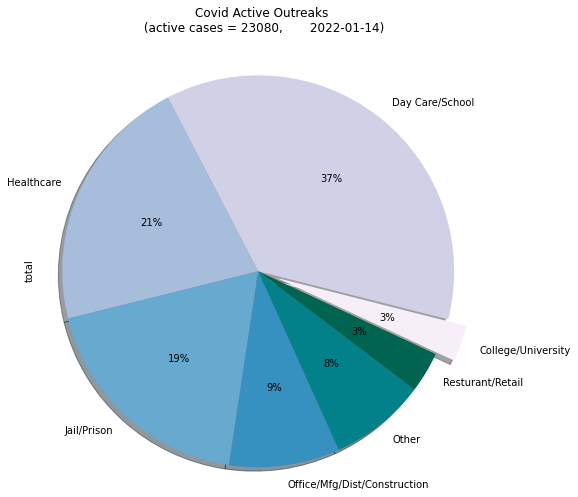

In [39]:
# creates a pie chart of the current total active cases
my_colors = ['#f6eff7','#d0d1e6','#a6bddb','#67a9cf','#3690c0','#02818a','#016450']

explode = (.1,0,0,0,0,0,0)

p.plot.pie(figsize=(8,8),explode=explode,autopct='%1.0f%%',
        shadow=True, colors=my_colors,startangle=-25);
plt.title(f'Covid Active Outreaks\n (active cases = {total_cases},       {day})\n')

plt.axis('equal')
plt.savefig(f'./covid_data_update/outbreaks-piechart-{day}.png');

In [40]:
# Gathering summary statistics for a two month pie chart 
# create datetime and integers types 
this_month = pd.read_csv(f'covid_data_update/outbreaks-DATE-{day}.csv')
this_month.date = pd.to_datetime(this_month.date)
this_month.total = this_month.total.astype(int)

In [41]:
# apply custom pie function
this_month = pie(this_month)

In [42]:
# Create string variables for the first day of the previous month and previous month
start = today - pd.offsets.MonthBegin (2)
str_date = start.strftime('%Y-%m-%d')
str_date
month = start.strftime('%B')
month

'2021-12-01'

'December'

In [43]:
#set filter to start month (month always starts on the first)
#check for new types
start_month = this_month[this_month.date > str_date].copy()
start_month = check_types(start_month)

['Municipal/Local Government'] were added to the category: Other


In [44]:
start_month = start_month.groupby('type').total.sum()
this_month_cases = start_month.sum()
start_month

type
College/University                21
Day Care/School                  627
Healthcare                      2808
Jail/Prison                      433
Office/Mfg/Dist/Construction     103
Other                            461
Resturant/Retail                 107
Name: total, dtype: int64

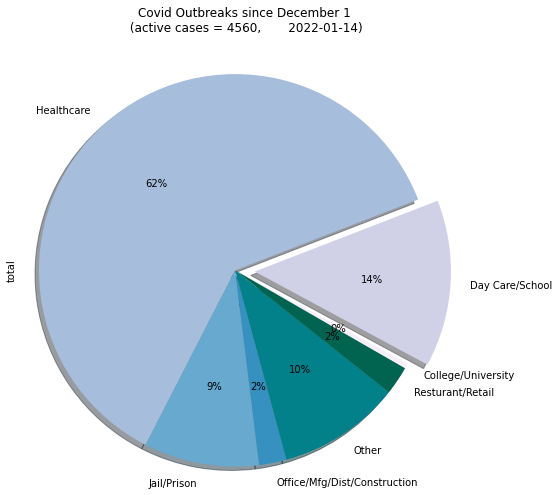

In [45]:
# creates a pie chart 
my_colors = ['#f6eff7','#d0d1e6','#a6bddb','#67a9cf','#3690c0','#02818a','#016450']

explode = (0,.1,0,0,0,0,0)

start_month.plot.pie(figsize=(8,8),explode=explode,autopct='%1.0f%%', 
             shadow=True, colors=my_colors,startangle=-30)

plt.title(f'Covid Outbreaks since {month} 1\n (active cases = {this_month_cases},       {day})\n')

plt.axis('equal')
plt.savefig(f'covid_data_update/this_month_outbreaks-piechart-{day}.png');

### Displays all updated graphs files

In [45]:
'''
This cell has been commented out to see if this improves loading times

!ls -t1 covid_data_update | head -n 20 | grep -ve '^bolder' -ve 'png$' -ve 'xlsx$' > covid_text
!ls covid_data_update/*.png > flist_of_covid_png 

# Loop through the file flist and store filenames in png_list
with open('flist_of_covid_png') as f:
    png_str = f.read()
png_list = png_str.split('\n')[0:-1]

png_list

from IPython.display import Image

for file in png_list:    
    local = Image(file)
    local
  '''

"\nThis cell has been commented out to see if this improves loading times\n\n!ls -t1 covid_data_update | head -n 20 | grep -ve '^bolder' -ve 'png$' -ve 'xlsx$' > covid_text\n!ls covid_data_update/*.png > flist_of_covid_png \n\n# Loop through the file flist and store filenames in png_list\nwith open('flist_of_covid_png') as f:\n    png_str = f.read()\npng_list = png_str.split('\n')[0:-1]\n\npng_list\n\nfrom IPython.display import Image\n\nfor file in png_list:    \n    local = Image(file)\n    local\n  "

In [46]:
    
# These were helper files and are not needed any longer
!rm -f covid_text
!rm -f flist_of_covid_png
!rm -f temp.xlsx

### More Detailed Inquiry

In [47]:
# create dfs for both active and resolved sheets 
for i in range(2):
    i=i+1
    df = pd.read_excel(f'covid_data/covid_report_{current_report}.xlsx',sheet_name=i,parse_dates=['Date reported to public health'])
    #df = pd.read_excel('~/Desktop/covid-19-data/covid_data/covid_report_2021-12-22.xlsx',sheet_name=i,parse_dates=['Date reported to public health'])
    df = df.iloc[:,:16]
    df = polish_report(df)
    
    
    df = df.sort_index(ascending=False)
    if i == 1: 
        active = df
    elif i == 2: 
        resolved = df

In [48]:
pd.options.display.max_rows = 300
pd.options.display.min_rows = 200

#### Select start and stop dates:

In [49]:
# Default conditions are set in module date_select
# Default start/stop is 2021-10-01 to 2021-10-31.
# Custom stop date, default is today

In [50]:
import date_select as ds
start,stop = ds.date_maker()

 Select START date


 2021-10


START:	 2021-10-01 00:00:00
STOP:	 2022-01-14


Select custom STOP date? (y/n)   y
Enter a STOP date   2021-11



START:	 2021-10-01 00:00:00
STOP:	 2021-11-01 00:00:00


In [51]:
adf = active[active.index.to_series().between(start,stop)]

rdf = resolved[resolved.index.to_series().between(start,stop)]

count1 = adf.total.sum(); print (f'Active: {count1}')
count2 = rdf.total.sum(); print(f'Resolved: {count2}')
print(f'Total cases for selected period was {count1 + count2}')
print(f'This represents {adf.shape[0]} active sites')
print(f'This represents {rdf.shape[0]} resolved sites')

Active: 3422
Resolved: 3367
Total cases for selected period was 6789
This represents 131 active sites
This represents 294 resolved sites


#### For Boulder county information use:

In [52]:
boulder_active = adf[adf.county == 'Boulder']
boulder_active

,total,name,type,county,residents,staff,attendee
date,,,,,,,
2021-11-01,16,Hygiene Elementary School,School K-12,Boulder,0,1,15
2021-10-24,14,Ned's Restaurant,Restaurant - Sit Down,Boulder,0,14,0
2021-10-12,20,Burlington Elementary School,School K-12,Boulder,0,1,19
2021-10-07,20,Ryan Elementary School,School K-12,Boulder,0,0,20
2021-10-05,7,Longmont High School: October 2021,School K-12,Boulder,0,0,7


### tabla rasa

In [ ]:
!ls covid_data_update

In [ ]:
!rm -rf covid_data_update